In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
import os
import matplotlib.pyplot as plt

Prepare training data
===

In [8]:
import splitfolders

In [10]:
train_src = "asl_alphabet_train"
splitfolders.ratio(train_src, output="datasets",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # 產生trian(訓練集)、val(驗證集)、test(測試集)

Copying files: 87000 files [00:35, 2424.07 files/s]


In [2]:
train_dir = 'datasets/train'
val_dir = 'datasets/val'
test_dir  = 'datasets/test'

Preprocessing and Get labels
===

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32
target_size = (32,32)
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen   = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen  = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory( # 多目錄時，目錄名為標籤
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

Found 69600 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [5]:
labels = list(train_generator.class_indices.keys())
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [22]:
from PIL import Image
def sample_images(labels): # show image datasets
    num_cols = 7
    num_rows = 4
    fig = plt.figure(figsize=(2*num_cols, 2*num_rows))
    counter = 0  # 用于计数当前子图的索引
    
    for label in labels:
        label_dir = os.path.join(train_dir, label)
        image_files = os.listdir(label_dir)[:num_rows*num_cols]
        
        for image_file in image_files:
            image_path = os.path.join(label_dir, image_file)
            image = Image.open(image_path)
            
            counter += 1  # 更新当前子图的索引
            if counter <= num_rows * num_cols:
                ax = plt.subplot(num_rows, num_cols, counter)
                plt.imshow(image)
                plt.axis("off")
                ax.title.set_text(label)
    
    plt.tight_layout()
    plt.show()

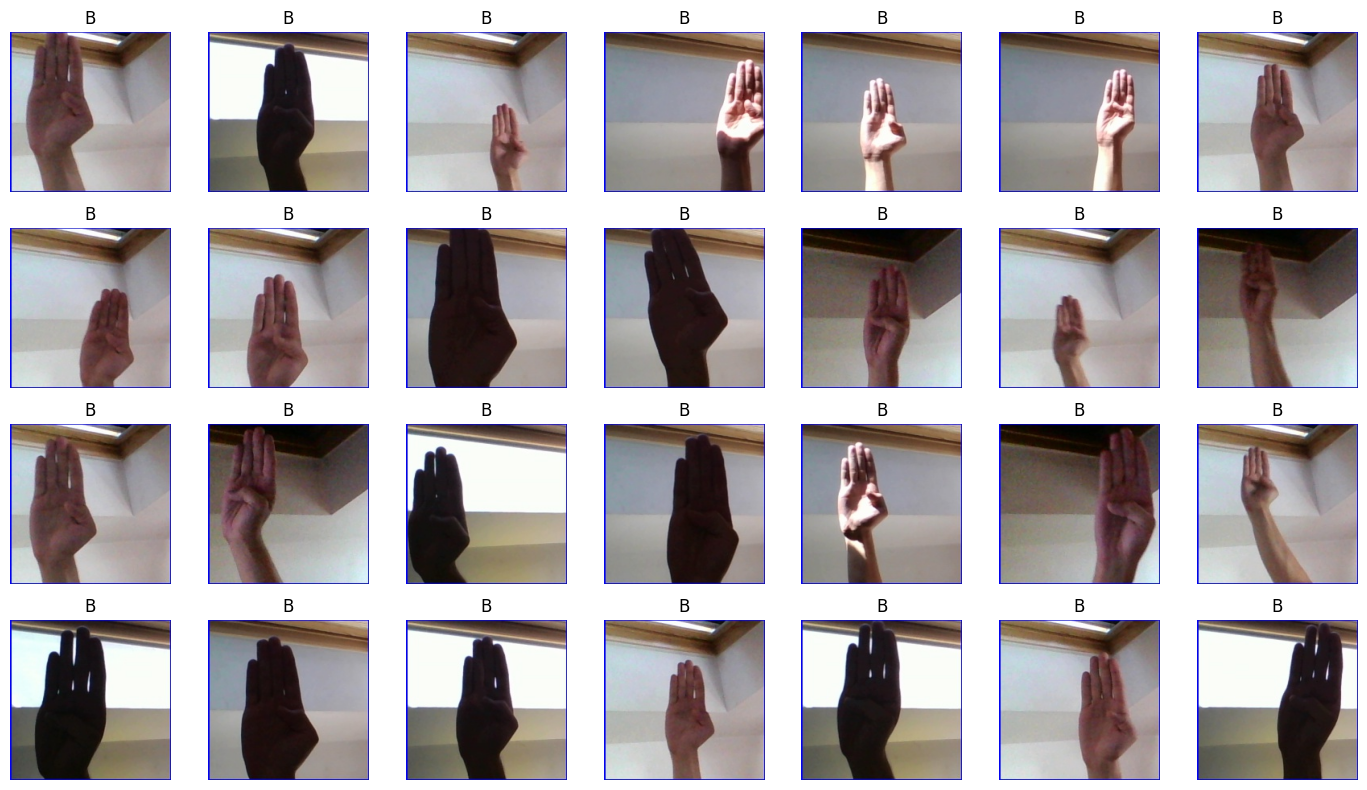

In [25]:
sample_images(labels[1])

Model
===

In [28]:
num_classes = len(labels)
input_shape=(32,32,1)
# cnn body
model = models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                      

Start training
===

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [31]:
checkpoint_path = "model/B_best_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [33]:
history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[checkpoint])

Epoch 1/10
2175/2175 [==============================] - ETA: 0s - loss: 0.8066 - accuracy: 0.7473
Epoch 1: val_accuracy improved from -inf to 0.83000, saving model to model/B_best_model.keras
2175/2175 [==============================] - 149s 67ms/step - loss: 0.8066 - accuracy: 0.7473 - val_loss: 0.5398 - val_accuracy: 0.8300
Epoch 2/10
2175/2175 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9448
Epoch 2: val_accuracy did not improve from 0.83000
2175/2175 [==============================] - 89s 41ms/step - loss: 0.1617 - accuracy: 0.9448 - val_loss: 1.9374 - val_accuracy: 0.6966
Epoch 3/10
2174/2175 [============================>.] - ETA: 0s - loss: 0.1028 - accuracy: 0.9660
Epoch 3: val_accuracy improved from 0.83000 to 0.90437, saving model to model/B_best_model.keras
2175/2175 [==============================] - 81s 37ms/step - loss: 0.1028 - accuracy: 0.9660 - val_loss: 0.3284 - val_accuracy: 0.9044
Epoch 4/10
2175/2175 [==============================] - ET

In [2]:
# def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
#     fig, ax = plt.subplots(figsize=(15, 4)) # ax 軸
#     if not (isintance(metric_name, list)) or (isintance(metric_name, tuple)): # 轉換列表
#         metrics=[metrics,]
#         metric_name=[metric_name,]

#     for idx, metric in enumerate(metrics):
#         ax.plot(metric, color=color[idx])
#     plt.xlabel("Epoch")
#     plt.ylabel(ylabel)
#     plt.xlim([0, TrainingConfig.EPOCHES-1])
#     plt.ylim(ylim)
    
print(TrainingConfig)

NameError: name 'TrainingConfig' is not defined

In [34]:
scores = model.evaluate(test_generator) 
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

272/272 [==============================] - 11s 42ms/step - loss: 0.0891 - accuracy: 0.9708
Test loss:  0.08905266225337982
Test accuracy:  0.9708045721054077


In [35]:
model.save("model/B_best_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
